In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/beijing/Beijing.csv


# XGBoost

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and preprocess data
data = pd.read_csv("/kaggle/input/beijing/Beijing.csv")
data = data.fillna(method='ffill')
data['wd'] = data['wd'].astype('category').cat.codes

# Feature selection and feature engineering
data['TEMP_WSPM'] = data['TEMP'] * data['WSPM']  # Interaction feature
X = data[['year', 'month', 'hour', 'TEMP', 'PRES', 'RAIN', 'WSPM', 'PM10', 'SO2', 'NO2', 'TEMP_WSPM']]
y = data['PM2.5']

# Reduce dataset size (sample synchronously)
sampled_indices = data.sample(frac=0.3, random_state=42).index
X = X.loc[sampled_indices]
y = y.loc[sampled_indices]

# Train-test split (with shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

# Train XGBoost model with optimized parameters (CPU-only)
model = xgb.XGBRegressor(
    n_estimators=500,  # Reduced number of trees
    learning_rate=0.05,  # Moderate learning rate
    max_depth=6,  # Deeper trees for complex patterns
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)

# Evaluate model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}")
print(f"R2: {r2}")

/tmp/ipykernel_30/1177495754.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


[0]	validation_0-rmse:77.05545
[10]	validation_0-rmse:53.79569
[20]	validation_0-rmse:41.06198
[30]	validation_0-rmse:34.44241
[40]	validation_0-rmse:31.11613
[50]	validation_0-rmse:29.53362
[60]	validation_0-rmse:28.53209
[70]	validation_0-rmse:27.97991
[80]	validation_0-rmse:27.60622
[90]	validation_0-rmse:27.27867
[100]	validation_0-rmse:27.12547
[110]	validation_0-rmse:26.98251
[120]	validation_0-rmse:26.78653
[130]	validation_0-rmse:26.69441
[140]	validation_0-rmse:26.56881
[150]	validation_0-rmse:26.44511
[160]	validation_0-rmse:26.38413
[170]	validation_0-rmse:26.26719
[180]	validation_0-rmse:26.18864
[190]	validation_0-rmse:26.10273
[200]	validation_0-rmse:26.03741
[210]	validation_0-rmse:25.98602
[220]	validation_0-rmse:25.93810
[230]	validation_0-rmse:25.88435
[240]	validation_0-rmse:25.80402
[250]	validation_0-rmse:25.73867
[260]	validation_0-rmse:25.67141
[270]	validation_0-rmse:25.63571
[280]	validation_0-rmse:25.61727
[290]	validation_0-rmse:25.57079
[300]	validation_0-rm

# GRU

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2190/2190 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Model Evaluation Metrics:
Mean Squared Error: 475.78
Mean Absolute Error: 13.49
Root Mean Squared Error: 21.81
Mean Absolute Percentage Error: 35.32%
R² Score: 92.68%


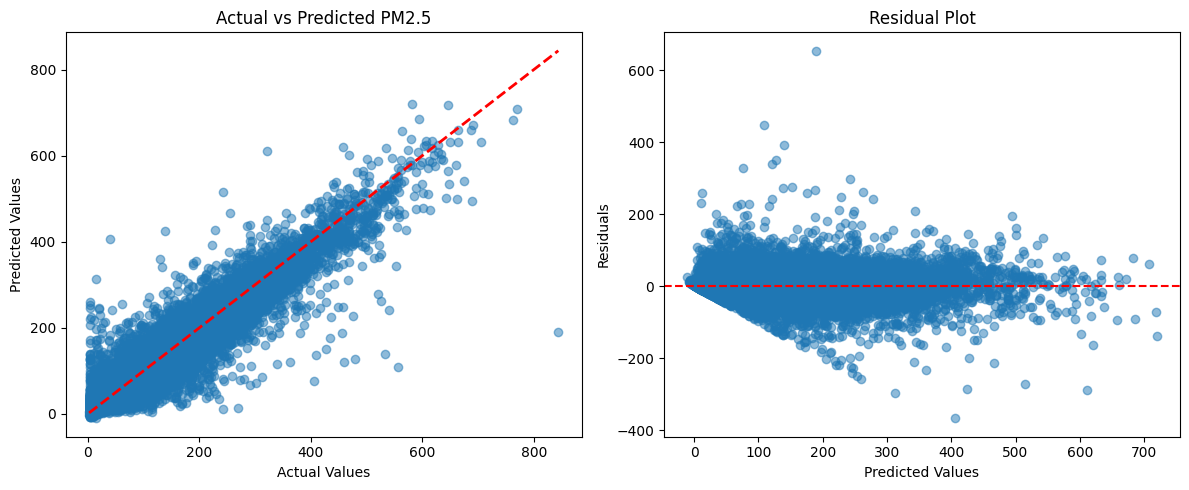

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data Loading and Preprocessing
def load_and_preprocess_data(file_path=None, data=None):
    # If file path is provided, load data
 
    df = pd.read_csv(file_path)
    df.drop(['No', 'station'], axis=1, inplace=True)
#     df = df[:30000]
    df.dropna(inplace=True)
    # Feature selection (excluding categorical columns)
    feature_columns = ['year', 'month', 'day', 'hour', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 
                       'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
    target_column = 'PM2.5'
    
    # Separate features and target
    X = df[feature_columns].values
    y = df[target_column].values
    
    # Normalize features
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    # Create sequences (look back of 24 hours)
    look_back = 24
    X_sequences, y_sequences = [], []
    for i in range(len(X_scaled) - look_back):
        X_sequences.append(X_scaled[i:i+look_back])
        y_sequences.append(y_scaled[i+look_back])
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y_sequences, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

# Build GRU Model
def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train Model
def train_model(X_train, y_train, X_test, y_test):
    model = build_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train, 
        epochs=15, 
        batch_size=32, 
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )
    
    return model, history

# Evaluate Model
def evaluate_model(model, X_test, y_test, scaler_y):
    # Predictions
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)
    
    # Metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Print Metrics
    print("Model Evaluation Metrics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Percentage Error: {mape:.2%}")
    print(f"R² Score: {r2:.2%}")
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    # Actual vs Predicted Plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Actual vs Predicted PM2.5')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    
    # Residual Plot
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    }

# Main Execution Function
def run_pm25_prediction(file_path=None, data=None):
    # Preprocess Data
    X_train, X_test, y_train, y_test, scaler_X, scaler_y = load_and_preprocess_data(
        file_path, data
    )
    
    # Train Model
    model, history = train_model(X_train, y_train, X_test, y_test)
    
    # Evaluate Model
    metrics = evaluate_model(model, X_test, y_test, scaler_y)
    
    return model, metrics

# Example Usage (Uncomment and modify as needed)
model, metrics = run_pm25_prediction(file_path='/kaggle/input/beijing/Beijing.csv')

# GRU WITH XGBOOST

8759/8759 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


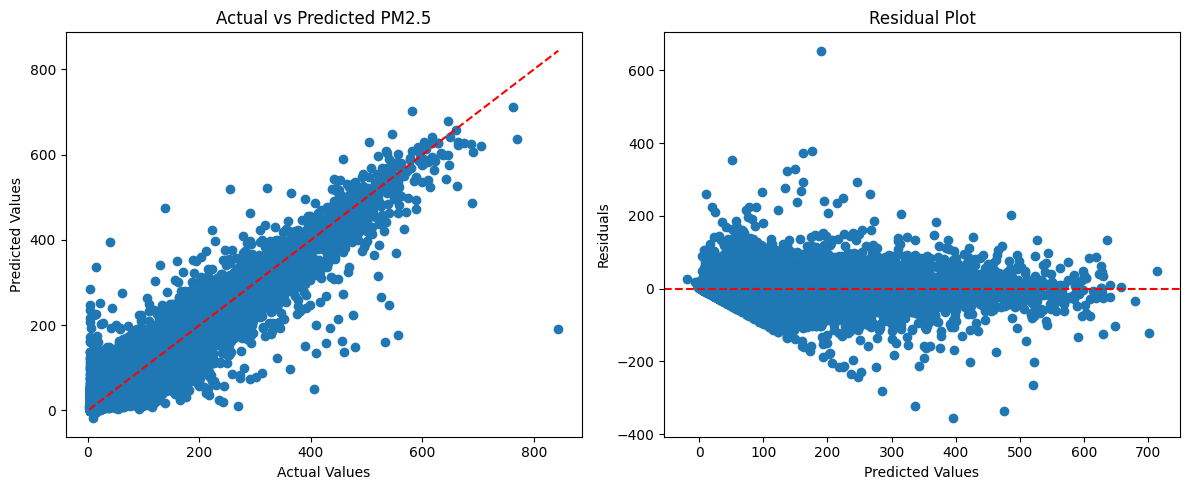

Hybrid Model Metrics:
MSE: 391.6726
MAE: 12.0522
RMSE: 19.7907
R² Score: 0.9397


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, GRU, Dense, Dropout, 
    MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
import xgboost as xgb

class XGBoostGRUHybridModel:
    def __init__(self, look_back=24, features=14):
        self.look_back = look_back
        self.features = features
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.hybrid_model = None
        self.xgboost_model = None

    def preprocess_data(self, df):
        df.drop(['No', 'station'], axis=1, inplace=True)
    #     df = df[:30000]
        df.dropna(inplace=True)
        feature_columns = ['year', 'month', 'day', 'hour', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 
                           'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
        target_column = 'PM2.5'
        
        X = df[feature_columns].values
        y = df[target_column].values
        
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
        
        return X_scaled, y_scaled

    def create_sequences(self, X, y):
        X_sequences, y_sequences = [], []
        for i in range(len(X) - self.look_back):
            X_sequences.append(X[i:i+self.look_back])
            y_sequences.append(y[i+self.look_back])
        
        return np.array(X_sequences), np.array(y_sequences)

    def build_hybrid_model(self):
        # Time series input
        input_layer = Input(shape=(self.look_back, self.features))
        
        # GRU with Multi-Head Attention
        gru_layer = GRU(64, return_sequences=True)(input_layer)
        
        # Multi-Head Attention
        attention_layer = MultiHeadAttention(
            num_heads=4, 
            key_dim=64
        )(gru_layer, gru_layer)
        
        # Normalization
        normalized = LayerNormalization()(attention_layer + gru_layer)
        
        # Global GRU
        global_gru = GRU(32)(normalized)
        
        # Dense layers
        dense1 = Dense(64, activation='relu')(global_gru)
        dropout = Dropout(0.2)(dense1)
        output = Dense(1)(dropout)
        
        # Create model
        model = Model(inputs=input_layer, outputs=output)
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        return model

    def train_hybrid_model(self, X_train, y_train, X_test, y_test):
        # Train GRU part
        self.hybrid_model = self.build_hybrid_model()
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        self.hybrid_model.fit(
            X_train, y_train, 
            epochs=100, 
            batch_size=32, 
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Train XGBoost on residuals
        gru_preds = self.hybrid_model.predict(X_train)
        xgb_train_target = y_train - gru_preds.ravel()
        
        # Flatten input for XGBoost
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        
        self.xgboost_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
        self.xgboost_model.fit(X_train_flat, xgb_train_target)

    def predict(self, X_test):
        # GRU predictions
        gru_preds = self.hybrid_model.predict(X_test)
        
        # XGBoost residual predictions
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        xgb_residuals = self.xgboost_model.predict(X_test_flat)
        
        # Combined predictions
        combined_preds = gru_preds.ravel() + xgb_residuals
        
        return combined_preds

    def evaluate_model(self, X_test, y_test):
        # Predictions
        y_pred = self.predict(X_test)
        
        # Inverse transform
        y_pred_original = self.scaler_y.inverse_transform(y_pred.reshape(-1, 1))
        y_true_original = self.scaler_y.inverse_transform(y_test.reshape(-1, 1))
        
        # Metrics
        mse = mean_squared_error(y_true_original, y_pred_original)
        mae = mean_absolute_error(y_true_original, y_pred_original)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true_original, y_pred_original)
        
        # Visualization
        plt.figure(figsize=(12, 5))
        
        # Actual vs Predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_true_original, y_pred_original)
        plt.plot([y_true_original.min(), y_true_original.max()], 
                 [y_true_original.min(), y_true_original.max()], 'r--')
        plt.title('Actual vs Predicted PM2.5')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        
        # Residual Plot
        plt.subplot(1, 2, 2)
        residuals = y_true_original - y_pred_original
        plt.scatter(y_pred_original, residuals)
        plt.title('Residual Plot')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print("Hybrid Model Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        
        return {'mse': mse, 'mae': mae, 'rmse': rmse, 'r2': r2}

    def run_prediction(self, df):
        # Preprocess data
        X_scaled, y_scaled = self.preprocess_data(df)
        
        # Create sequences
        X_sequences, y_sequences = self.create_sequences(X_scaled, y_scaled)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_sequences, y_sequences, test_size=0.2, random_state=42
        )
        
        # Train models
        self.train_hybrid_model(X_train, y_train, X_test, y_test)
        
        # Evaluate
        metrics = self.evaluate_model(X_test, y_test)
        
        return metrics

# Example Usage
df = pd.read_csv('/kaggle/input/beijing/Beijing.csv')
hybrid_model = XGBoostGRUHybridModel()
results = hybrid_model.run_prediction(df)